# Text Classification in Cross-Validation using Convolutional Neural Network

## Import Libraries

In [1]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

language="italian"

language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

### Model Parameters

In [3]:
batch_size = 128
number_of_filters = 100
filter_sizes = [1,2,3]
dropout_pc = 0.5
n_epochs = 100
patience=5
lr = 1e-3

nfold=10

### Dataset Parameters

In [4]:
path_db="../input/politica/politica.xlsx"
df = pd.read_excel(path_db, sheet_name="Foglio1")

text="testo"
review="cap_maj_master"

n_top_class=35

## Enable GPU

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [6]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


## Class Distribution Diagram

Number of Classes found:  21


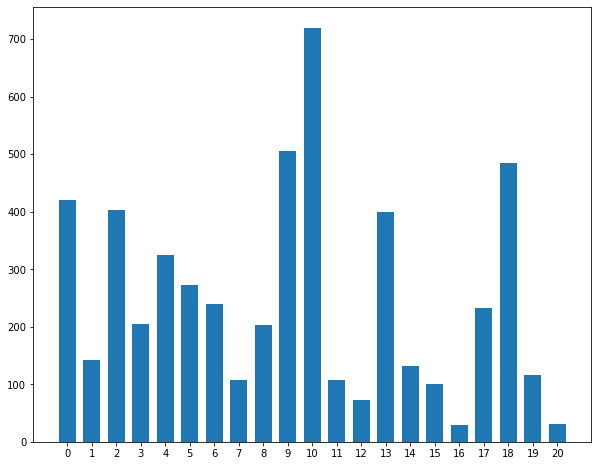

In [7]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


## Define Preprocessor

In [8]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [9]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [10]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print("Quantile sequence length: ",quant)

Max sequence length:  1375
Average sequence length:  201.02611015818562
Quantile sequence length:  248.0


## Vocabulary Build

In [11]:
vocaboli=set(line.strip() for line in open('../input/politica-p/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [12]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [13]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [14]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [15]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [16]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:40, 21449.74it/s]


There are 135327 / 279895 pretrained vectors found.


## Utility Functions

In [17]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [18]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

### Plot Function

In [19]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [20]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [21]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.n_embed, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, n_filters)
        self.fc2 = nn.Linear(n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        

        
        
    def forward(self, text,len_text):
        
        emb = self.embedding(text)
        emb=emb.transpose(2,1)
        conved = [F.relu(c(emb)) for c in self.convs] 
        #al max_pool1d diamo come parametro il filter size
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        out=self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

## Evaluate Function

In [22]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [23]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

## Define Predict Function

In [24]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

## Cross-Validation Loop

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.764463  | 294.676704 |   11.25   |   3.25   
Validation loss decreased (inf --> 294.676704).  Saving model ...
   2    |  352.071873  | 279.687764 |   18.59   |   2.64   
Validation loss decreased (294.676704 --> 279.687764).  Saving model ...
   3    |  314.174641  | 242.018360 |   33.12   |   2.61   
Validation loss decreased (279.687764 --> 242.018360).  Saving model ...
   4    |  268.171458  | 212.763223 |   40.53   |   2.58   
Validation loss decreased (242.018360 --> 212.763223).  Saving model ...
   5    |  230.407979  | 192.133833 |   44.12   |   2.60   
Validation loss decreased (212.763223 --> 192.133833).  Saving model ...
   6    |  200.473060  | 178.624373 |   48.94   |   2.59   
Validation loss decreased (192.133833 --> 178.624373).  Saving model ...


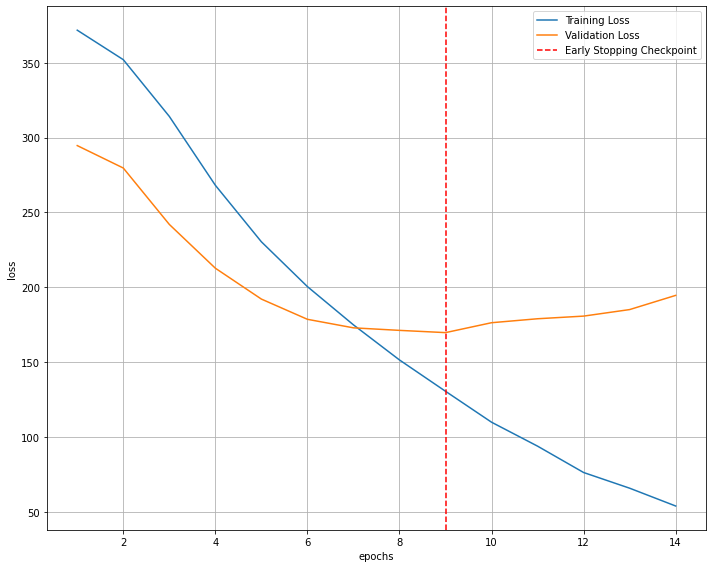

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.34      0.67      0.45        42
           1       0.12      0.07      0.09        15
           2       0.81      0.75      0.78        40
           3       0.72      0.62      0.67        21
           4       0.52      0.34      0.42        32
           5       0.77      0.85      0.81        27
           6       0.57      0.67      0.62        24
           7       0.40      0.18      0.25        11
           8       0.82      0.45      0.58        20
           9       0.72      0.78      0.75        50
          10       0.60      0.69      0.65        72
          11       0.00      0.00      0.00        11
          12       1.00      0.14      0.25         7
          13       0.29      0.28      0.28        40
          14       0.70      0.54      0.61        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

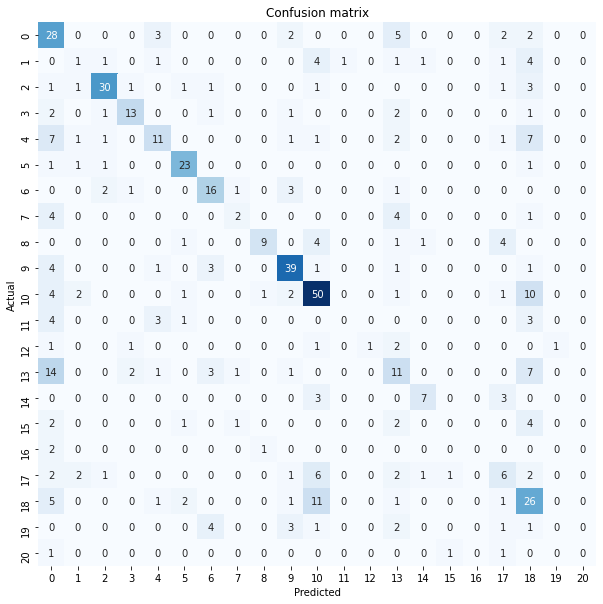


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  368.328938  | 293.038205 |   11.25   |   2.58   
Validation loss decreased (inf --> 293.038205).  Saving model ...
   2    |  348.962870  | 273.118710 |   17.97   |   2.61   
Validation loss decreased (293.038205 --> 273.118710).  Saving model ...
   3    |  306.470102  | 230.679995 |   34.22   |   2.58   
Validation loss decreased (273.118710 --> 230.679995).  Saving model ...
   4    |  256.543376  | 199.102500 |   44.90   |   2.60   
Validation loss decreased (230.679995 --> 199.102500).  Saving model ...
   5    |  218.552803  | 183.644386 |   47.25   |   2.58   
Validation loss decreased (199.102500 --> 183.644386).  Saving model ...
   6    |  191.781289  | 171.244868 |   49.59   |   2.61   
Validation loss decreased (183.644386 --> 171.244868).  Saving model ...

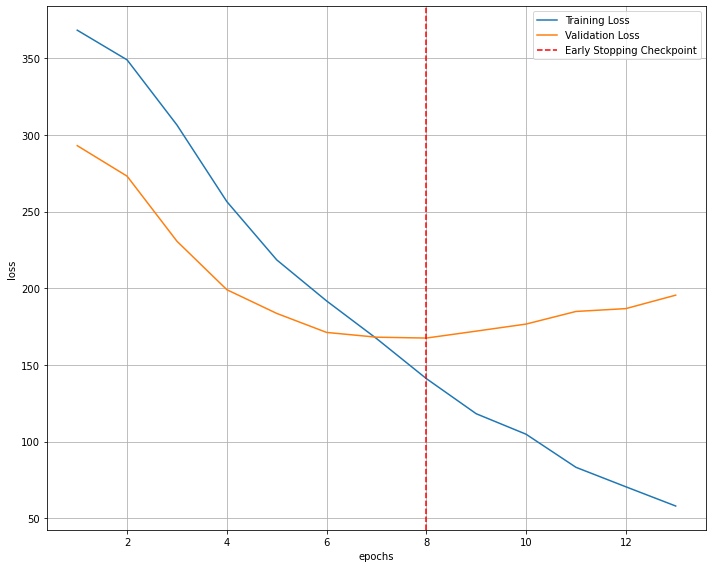

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.71      0.51        42
           1       0.30      0.20      0.24        15
           2       0.78      0.88      0.82        40
           3       0.56      0.90      0.69        20
           4       0.50      0.39      0.44        33
           5       0.88      0.79      0.83        28
           6       0.50      0.79      0.61        24
           7       0.25      0.09      0.13        11
           8       0.30      0.35      0.33        20
           9       0.81      0.86      0.83        50
          10       0.61      0.69      0.65        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.27      0.17      0.21        40
          14       0.43      0.23      0.30        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

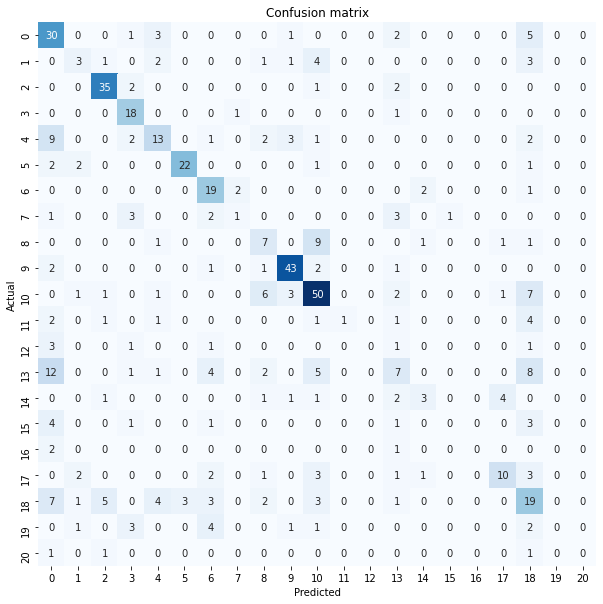


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.432494  | 293.273298 |   11.25   |   2.60   
Validation loss decreased (inf --> 293.273298).  Saving model ...
   2    |  352.979269  | 275.450276 |   17.03   |   2.59   
Validation loss decreased (293.273298 --> 275.450276).  Saving model ...
   3    |  309.927294  | 223.791470 |   35.31   |   2.63   
Validation loss decreased (275.450276 --> 223.791470).  Saving model ...
   4    |  265.775530  | 195.394803 |   47.56   |   2.61   
Validation loss decreased (223.791470 --> 195.394803).  Saving model ...
   5    |  228.496462  | 174.485771 |   50.66   |   2.59   
Validation loss decreased (195.394803 --> 174.485771).  Saving model ...
   6    |  199.725649  | 160.842741 |   52.85   |   2.58   
Validation loss decreased (174.485771 --> 160.842741).  Saving model ...

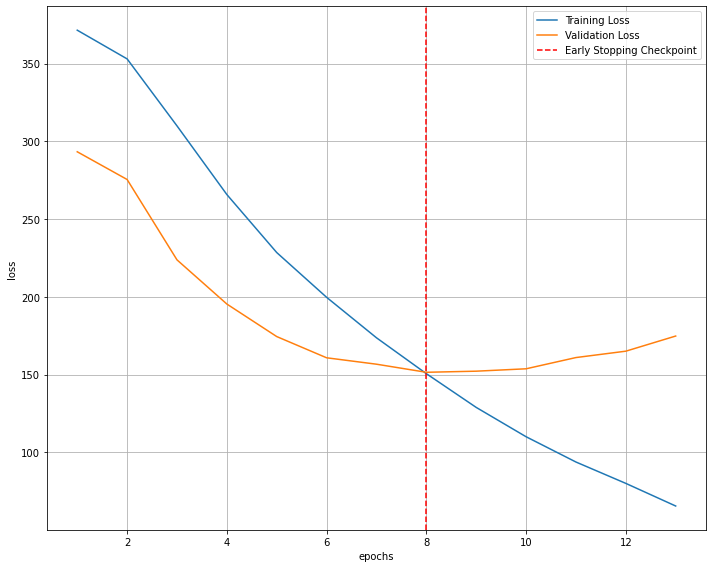

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.43      0.41        42
           1       1.00      0.14      0.25        14
           2       0.73      0.90      0.81        40
           3       0.55      0.80      0.65        20
           4       0.39      0.64      0.48        33
           5       0.71      0.89      0.79        28
           6       0.69      0.83      0.75        24
           7       1.00      0.36      0.53        11
           8       0.87      0.65      0.74        20
           9       0.75      0.88      0.81        50
          10       0.70      0.86      0.77        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.32      0.30      0.31        40
          14       0.58      0.54      0.56        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

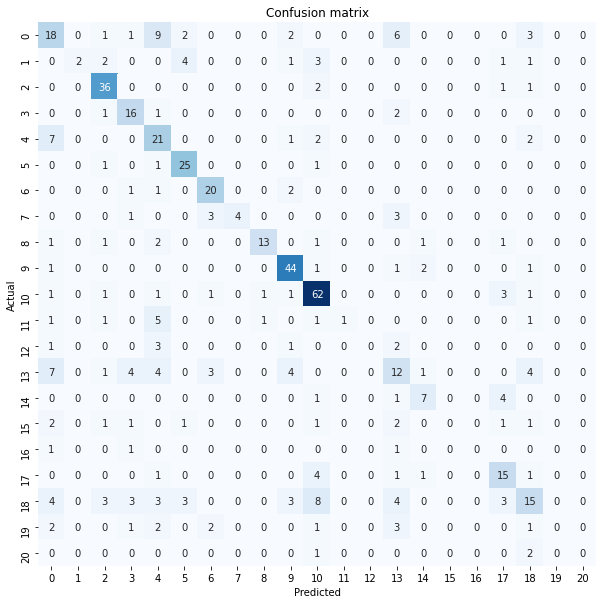


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.862253  | 293.335859 |   11.25   |   2.58   
Validation loss decreased (inf --> 293.335859).  Saving model ...
   2    |  351.358298  | 274.830896 |   17.34   |   2.58   
Validation loss decreased (293.335859 --> 274.830896).  Saving model ...
   3    |  314.776601  | 233.910989 |   36.83   |   2.58   
Validation loss decreased (274.830896 --> 233.910989).  Saving model ...
   4    |  265.774086  | 197.291897 |   44.72   |   2.58   
Validation loss decreased (233.910989 --> 197.291897).  Saving model ...
   5    |  233.346613  | 178.215897 |   49.41   |   2.60   
Validation loss decreased (197.291897 --> 178.215897).  Saving model ...
   6    |  203.651457  | 162.372678 |   54.25   |   2.59   
Validation loss decreased (178.215897 --> 162.372678).  Saving model ...

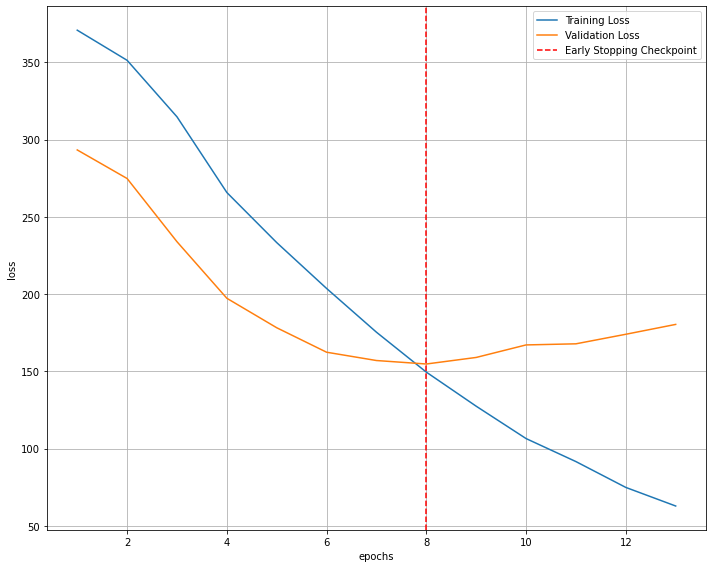

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.47      0.55      0.51        42
           1       0.62      0.36      0.45        14
           2       0.73      0.80      0.76        40
           3       0.50      0.50      0.50        20
           4       0.35      0.55      0.43        33
           5       0.62      0.89      0.74        28
           6       0.50      0.65      0.57        23
           7       0.00      0.00      0.00        11
           8       0.55      0.80      0.65        20
           9       0.78      0.86      0.82        50
          10       0.64      0.81      0.71        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.37      0.25      0.30        40
          14       0.47      0.64      0.55        14
          15       1.00      0.10      0.18        10
          16       0.00      0.00

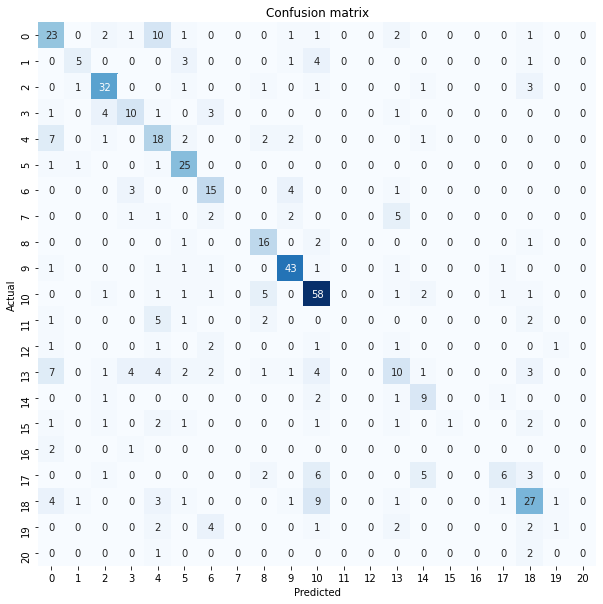


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.450071  | 292.660036 |   11.25   |   2.58   
Validation loss decreased (inf --> 292.660036).  Saving model ...
   2    |  352.055588  | 276.472824 |   19.22   |   2.61   
Validation loss decreased (292.660036 --> 276.472824).  Saving model ...
   3    |  315.045931  | 238.665095 |   33.12   |   2.59   
Validation loss decreased (276.472824 --> 238.665095).  Saving model ...
   4    |  268.795772  | 205.615800 |   41.67   |   2.60   
Validation loss decreased (238.665095 --> 205.615800).  Saving model ...
   5    |  229.204789  | 182.167872 |   47.72   |   2.59   
Validation loss decreased (205.615800 --> 182.167872).  Saving model ...
   6    |  200.383977  | 168.548064 |   51.78   |   2.61   
Validation loss decreased (182.167872 --> 168.548064).  Saving model ...

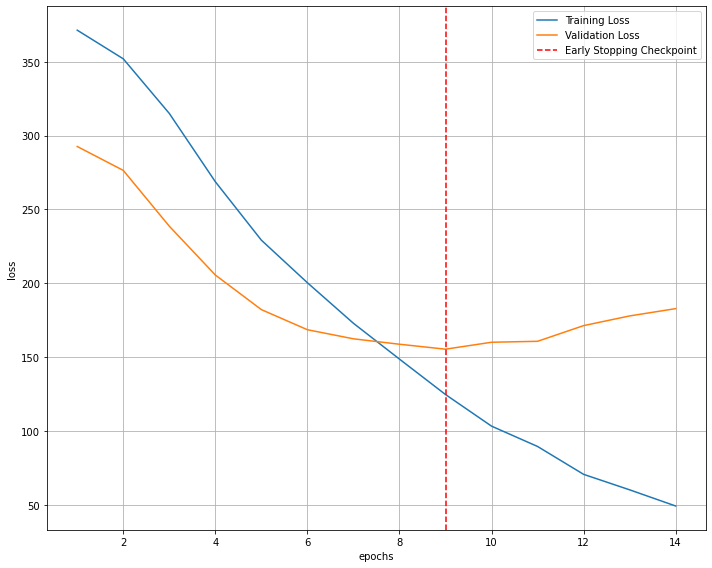

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.48      0.43        42
           1       0.60      0.21      0.32        14
           2       0.67      0.70      0.68        40
           3       0.85      0.85      0.85        20
           4       0.65      0.73      0.69        33
           5       0.58      0.78      0.67        27
           6       0.75      0.62      0.68        24
           7       0.53      0.73      0.62        11
           8       0.72      0.65      0.68        20
           9       0.74      0.84      0.79        51
          10       0.63      0.79      0.70        72
          11       0.67      0.18      0.29        11
          12       0.00      0.00      0.00         7
          13       0.39      0.40      0.40        40
          14       0.67      0.43      0.52        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

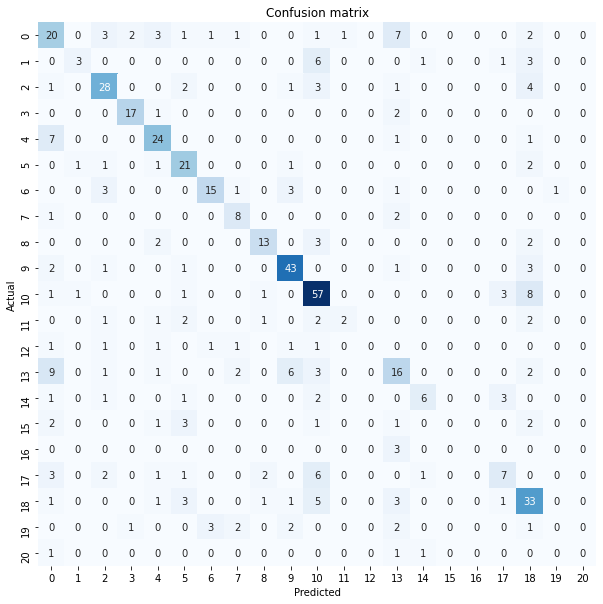


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.605766  | 293.018671 |   11.25   |   2.60   
Validation loss decreased (inf --> 293.018671).  Saving model ...
   2    |  350.688918  | 270.778913 |   21.88   |   2.59   
Validation loss decreased (293.018671 --> 270.778913).  Saving model ...
   3    |  307.906713  | 224.397278 |   34.53   |   2.61   
Validation loss decreased (270.778913 --> 224.397278).  Saving model ...
   4    |  263.577569  | 192.368572 |   44.90   |   2.58   
Validation loss decreased (224.397278 --> 192.368572).  Saving model ...
   5    |  226.678694  | 172.833894 |   54.65   |   2.60   
Validation loss decreased (192.368572 --> 172.833894).  Saving model ...
   6    |  196.394265  | 162.344194 |   54.96   |   2.59   
Validation loss decreased (172.833894 --> 162.344194).  Saving model ...

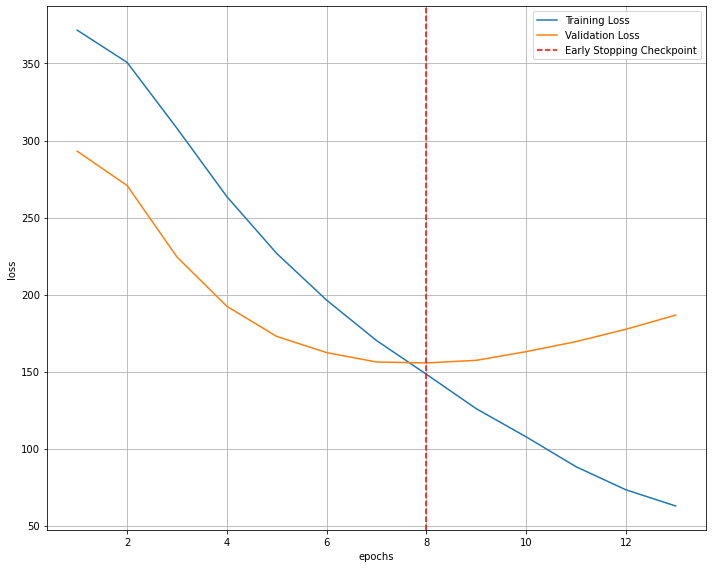

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.52      0.44        42
           1       0.17      0.07      0.10        14
           2       0.82      0.90      0.86        41
           3       0.59      0.85      0.69        20
           4       0.55      0.50      0.52        32
           5       0.77      0.89      0.83        27
           6       0.56      0.79      0.66        24
           7       0.00      0.00      0.00        11
           8       0.63      0.90      0.75        21
           9       0.66      0.88      0.76        51
          10       0.71      0.85      0.77        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.30      0.26      0.28        39
          14       0.64      0.69      0.67        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

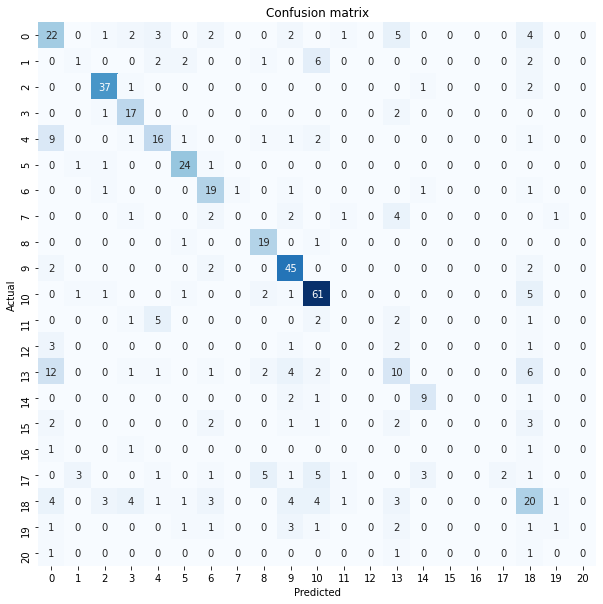


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.420427  | 292.464829 |   11.25   |   2.58   
Validation loss decreased (inf --> 292.464829).  Saving model ...
   2    |  352.892276  | 273.331896 |   18.28   |   2.61   
Validation loss decreased (292.464829 --> 273.331896).  Saving model ...
   3    |  313.873673  | 218.160140 |   35.94   |   2.59   
Validation loss decreased (273.331896 --> 218.160140).  Saving model ...
   4    |  266.734198  | 186.752538 |   40.73   |   2.59   
Validation loss decreased (218.160140 --> 186.752538).  Saving model ...
   5    |  231.706663  | 161.732596 |   51.11   |   2.59   
Validation loss decreased (186.752538 --> 161.732596).  Saving model ...
   6    |  198.535458  | 147.277163 |   54.86   |   2.59   
Validation loss decreased (161.732596 --> 147.277163).  Saving model ...

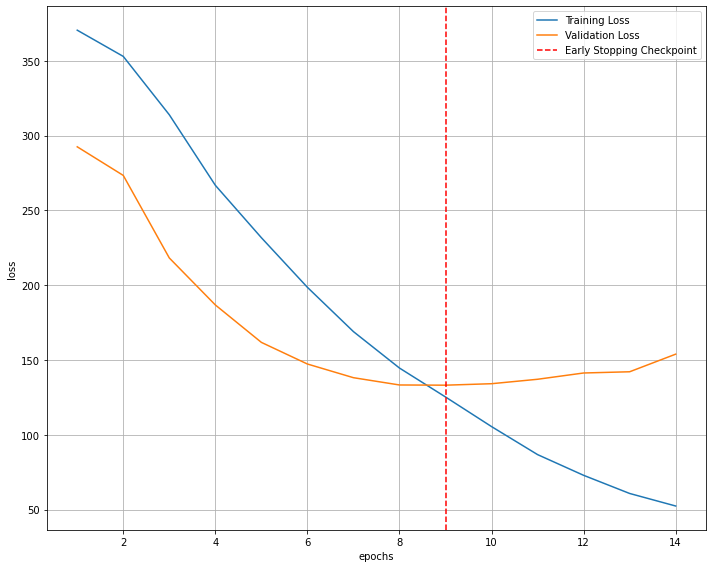

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.45      0.40        42
           1       0.50      0.21      0.30        14
           2       0.80      0.88      0.84        41
           3       0.75      0.71      0.73        21
           4       0.42      0.50      0.46        32
           5       0.74      0.96      0.84        27
           6       0.70      0.58      0.64        24
           7       0.50      0.30      0.37        10
           8       0.50      0.71      0.59        21
           9       0.92      0.86      0.89        51
          10       0.88      0.81      0.84        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.48      0.62      0.54        40
          14       0.70      0.54      0.61        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

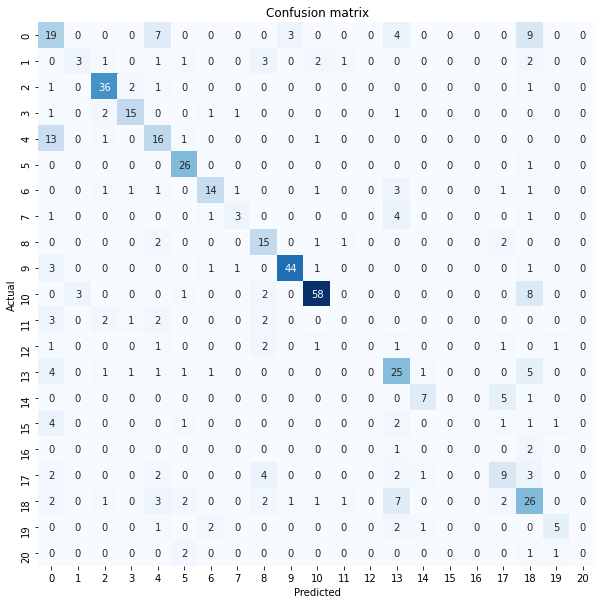


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.725958  | 291.425770 |   11.25   |   2.59   
Validation loss decreased (inf --> 291.425770).  Saving model ...
   2    |  352.784285  | 271.333569 |   21.88   |   2.81   
Validation loss decreased (291.425770 --> 271.333569).  Saving model ...
   3    |  310.372977  | 220.275053 |   33.59   |   2.59   
Validation loss decreased (271.333569 --> 220.275053).  Saving model ...
   4    |  266.820661  | 196.831969 |   39.95   |   2.61   
Validation loss decreased (220.275053 --> 196.831969).  Saving model ...
   5    |  234.498871  | 178.452521 |   43.80   |   2.59   
Validation loss decreased (196.831969 --> 178.452521).  Saving model ...
   6    |  202.925451  | 164.306477 |   50.57   |   2.59   
Validation loss decreased (178.452521 --> 164.306477).  Saving model ...

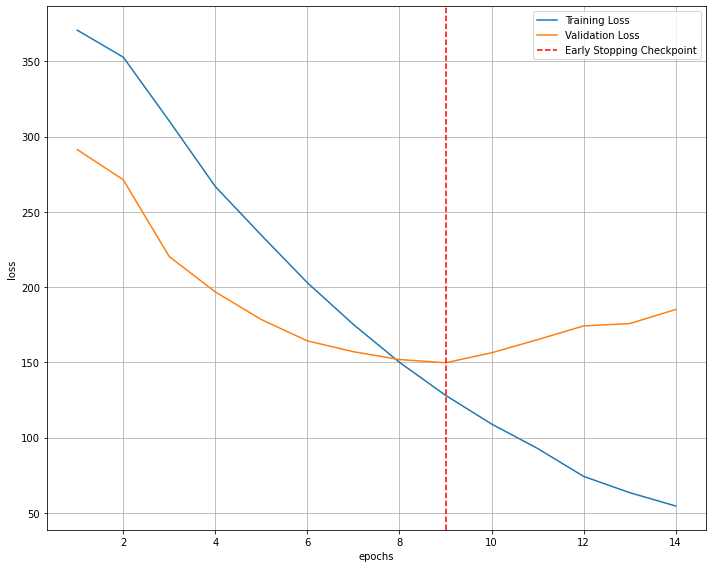

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.43      0.41        42
           1       0.17      0.07      0.10        14
           2       0.75      0.98      0.85        41
           3       0.61      0.95      0.74        21
           4       0.49      0.88      0.63        32
           5       0.82      0.85      0.84        27
           6       0.68      0.71      0.69        24
           7       0.80      0.40      0.53        10
           8       0.85      0.81      0.83        21
           9       0.77      0.73      0.75        51
          10       0.80      0.79      0.80        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.33      0.35      0.34        40
          14       0.75      0.23      0.35        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

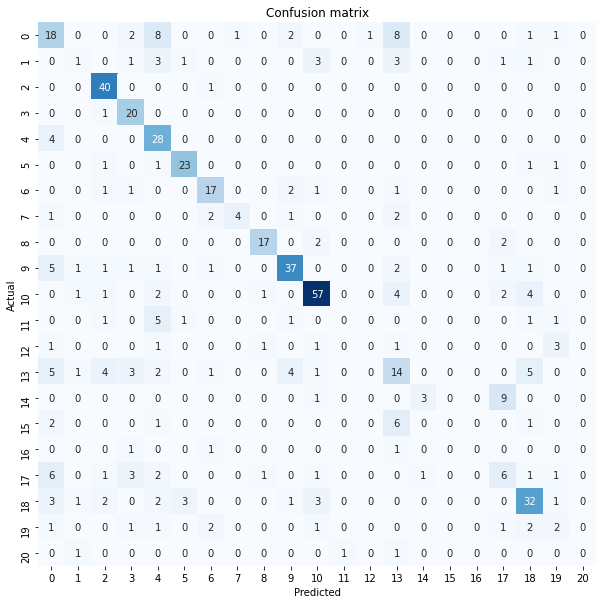


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  367.917174  | 291.531666 |   11.25   |   2.60   
Validation loss decreased (inf --> 291.531666).  Saving model ...
   2    |  352.207987  | 271.820208 |   18.28   |   2.59   
Validation loss decreased (291.531666 --> 271.820208).  Saving model ...
   3    |  308.210741  | 220.515440 |   33.91   |   2.60   
Validation loss decreased (271.820208 --> 220.515440).  Saving model ...
   4    |  260.100746  | 193.052847 |   45.57   |   2.59   
Validation loss decreased (220.515440 --> 193.052847).  Saving model ...
   5    |  223.011549  | 172.745145 |   56.30   |   2.60   
Validation loss decreased (193.052847 --> 172.745145).  Saving model ...
   6    |  192.949290  | 167.198224 |   57.71   |   2.60   
Validation loss decreased (172.745145 --> 167.198224).  Saving model ...

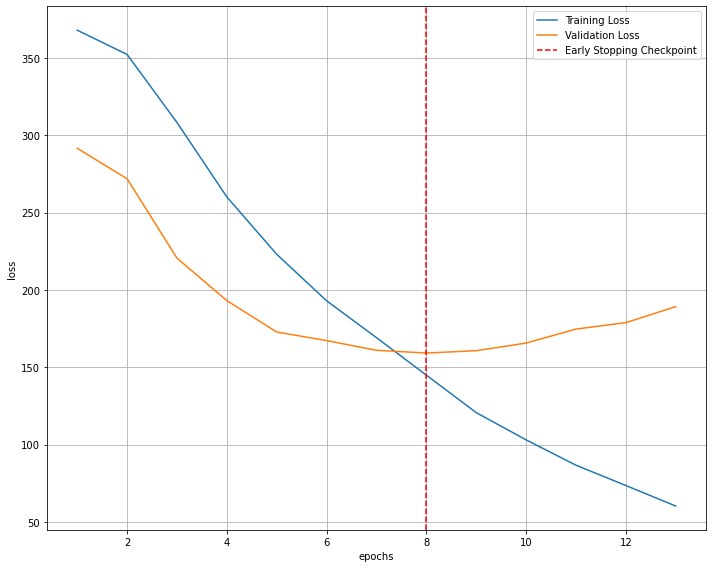

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.41      0.29      0.34        42
           1       0.44      0.29      0.35        14
           2       0.73      0.80      0.76        40
           3       0.70      0.90      0.79        21
           4       0.60      0.56      0.58        32
           5       0.59      0.85      0.70        27
           6       0.55      0.71      0.62        24
           7       0.67      0.20      0.31        10
           8       0.52      0.70      0.60        20
           9       0.71      0.82      0.76        51
          10       0.66      0.74      0.70        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.33      0.42      0.37        40
          14       0.64      0.54      0.58        13
          15       1.00      0.10      0.18        10
          16       0.00      0.00

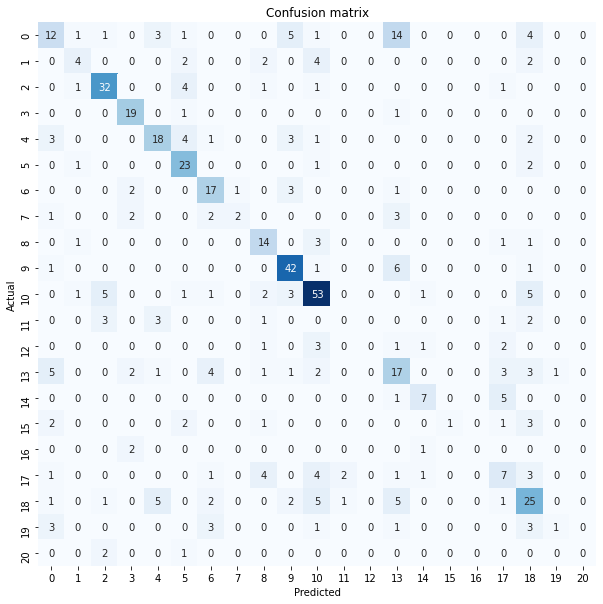


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.024220  | 291.914725 |   11.25   |   2.58   
Validation loss decreased (inf --> 291.914725).  Saving model ...
   2    |  352.084604  | 274.275556 |   17.97   |   2.60   
Validation loss decreased (291.914725 --> 274.275556).  Saving model ...
   3    |  310.668790  | 230.123722 |   40.42   |   2.59   
Validation loss decreased (274.275556 --> 230.123722).  Saving model ...
   4    |  264.037262  | 200.295997 |   40.16   |   2.60   
Validation loss decreased (230.123722 --> 200.295997).  Saving model ...
   5    |  231.527380  | 180.887572 |   48.80   |   2.59   
Validation loss decreased (200.295997 --> 180.887572).  Saving model ...
   6    |  200.613542  | 165.836114 |   52.97   |   2.63   
Validation loss decreased (180.887572 --> 165.836114).  Saving model ...

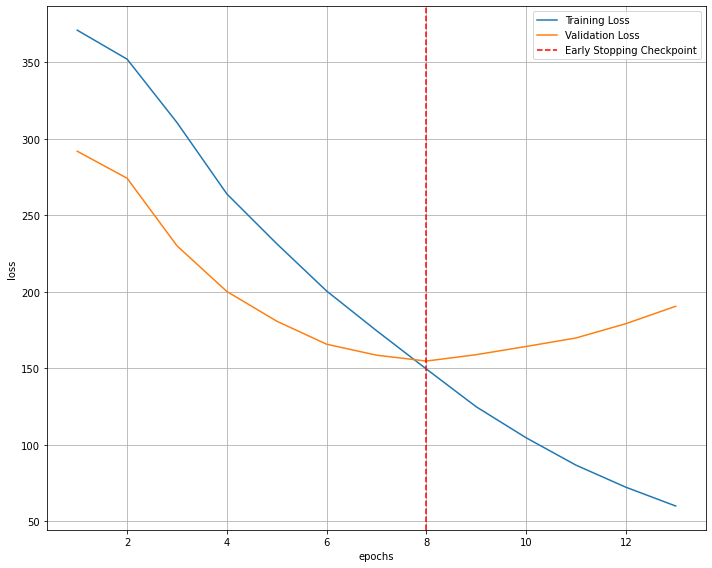

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.62      0.50      0.55        42
           1       0.17      0.07      0.10        15
           2       0.71      0.85      0.77        40
           3       0.65      0.81      0.72        21
           4       0.51      0.78      0.62        32
           5       0.62      0.89      0.73        27
           6       0.44      0.83      0.58        24
           7       0.67      0.55      0.60        11
           8       0.55      0.80      0.65        20
           9       0.75      0.86      0.80        50
          10       0.66      0.57      0.61        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.34      0.40      0.37        40
          14       0.70      0.54      0.61        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

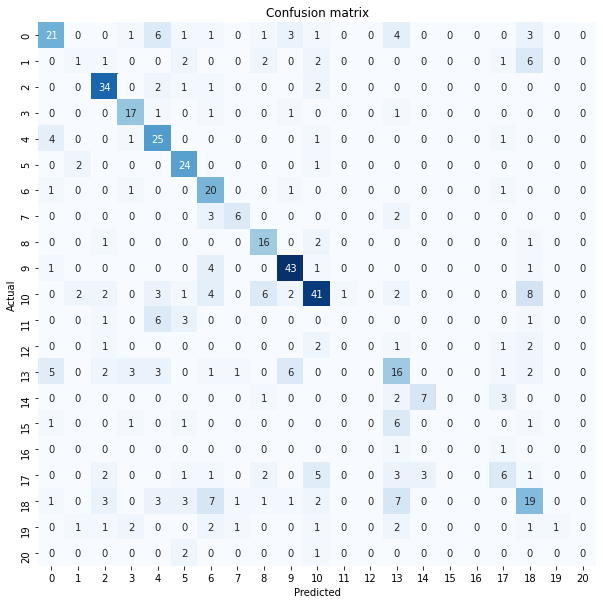

In [25]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=output_dim,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


## Results Output

In [26]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 57.39 +/- 2.85 max: 61.14

CV precision: 54.66 +/- 2.70 max: 59.25

CV recall: 57.39 +/- 2.85 max: 61.14

CV f1: 54.26 +/- 3.02 max: 59.50

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 41.63  +/- 7.47  | 50.24 +/-11.64  | 44.54 +/- 6.04  |   42.00  
   1    | 40.94  +/-26.66  | 16.90 +/- 9.73  | 22.90 +/-12.23  |   14.30  
   2    | 75.30  +/- 4.70  | 84.31 +/- 7.71  | 79.40 +/- 5.07  |   40.30  
   3    | 64.86  +/-10.19  | 79.00 +/-13.36  | 70.43 +/- 8.79  |   20.50  
   4    | 49.88  +/- 8.70  | 58.66 +/-16.02  | 52.62 +/- 9.12  |   32.40  
   5    | 71.13  +/- 9.82  | 86.46 +/- 5.17  | 77.60 +/- 6.06  |   27.30  
   6    | 59.43  +/- 9.80  | 71.94 +/- 8.45  | 64.14 +/- 5.38  |   23.90  
   7    | 48.17  +/-31.08  | 28.09 +/-22.38  | 33.48 +/-22.41  |   10.70  
   8    | 63.17  +/-17.20  | 68.29 +/-16.16  | 63.98 +/-12.91  |   20.30  
   9    | 76.18  +/- 6.46  |